In [1]:
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import root_mean_squared_error
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from datetime import timedelta
from datetime import datetime
import lightgbm as lgb
import datetime as dt
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression
import math
import sys
import re
import os

sns.set_theme(style="darkgrid")

import utils as utils
import utils_plots as utils_plots
from utils_models import ForecastingModel

In [35]:
file_path = 'train_v_2_kaggle_23.csv'
df_kaggle = pd.read_csv(file_path)

In [36]:
# Formatting
df_kaggle['date'] = pd.to_datetime(df_kaggle['date'], format='%Y-%m-%d', errors='coerce')
df_kaggle['sales_units'] = pd.to_numeric(df_kaggle['sales_units'], errors='coerce')
df_kaggle['inventory_units'] = pd.to_numeric(df_kaggle['inventory_units'], errors='coerce')

df_kaggle['sku'] = df_kaggle['reporterhq_id'].astype(str) + "_" + df_kaggle['product_number'].astype(str)

categorical_columns = ['id', 'product_number', 'reporterhq_id', 'prod_category', 'display_size', 'segment', 'sku']
for col in categorical_columns:
    df_kaggle[col] = df_kaggle[col].astype('category')

In [37]:
# df_kaggle.drop(columns=['specs', 'id'], inplace=True)
df_kaggle.drop(columns=['specs'], inplace=True)

In [38]:
# Resample weekly for each sku
# utils.looks_for_missing_dates(df_kaggle)
df_kaggle = utils.fill_in_missing_dates(df_kaggle)

/Users/matteogiaretti/Python/hp_use case/utils.py:34: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_dates_ranges = df.groupby(group_col)[date_col].agg(['min', 'max']).reset_index()


In [39]:
# Interpolation and fill-in function
def interpolate_sku(group):
    group = group.sort_values(by='date')
    group = group.set_index('date')  
    group['sales_units'] = group['sales_units'].interpolate(method='time')
    group['inventory_units'] = group['inventory_units'].interpolate(method='time')
    return group.reset_index()

df_kaggle = df_kaggle.groupby('sku', group_keys=False).apply(interpolate_sku)
df_kaggle = df_kaggle.dropna(subset=['inventory_units'])

/var/folders/0b/l6j0p2ks77sdrd0y2c4876p40000gn/T/ipykernel_63819/1924472382.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_kaggle = df_kaggle.groupby('sku', group_keys=False).apply(interpolate_sku)
/var/folders/0b/l6j0p2ks77sdrd0y2c4876p40000gn/T/ipykernel_63819/1924472382.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_kaggle = df_kaggle.groupby('sku', group_keys=False).apply(interpolate_sku)


In [40]:
df_kaggle['day_of_month'] = df_kaggle['date'].dt.day
df_kaggle['week_of_month'] = (df_kaggle['date'].dt.day - 1) // 7 + 1  # Week within the month
df_kaggle['week_of_year'] = df_kaggle['date'].dt.isocalendar().week  # ISO week number
df_kaggle['month_of_year'] = df_kaggle['date'].dt.month
df_kaggle['year'] = df_kaggle['date'].dt.year

In [41]:
# Define lags and lag column names
lags = [13, 14, 15]
lag_cols_inventory = [f"lag_{lag}_inventory" for lag in lags]
lag_cols_sales = [f"lag_{lag}_sales" for lag in lags]

# Generate lag columns for inventory_units
for lag, lag_col in zip(lags, lag_cols_inventory):
    df_kaggle[lag_col] = df_kaggle.groupby("sku", observed=False)["inventory_units"].shift(lag)

# Generate lag columns for sales_units
for lag, lag_col in zip(lags, lag_cols_sales):
    df_kaggle[lag_col] = df_kaggle.groupby("sku", observed=False)["sales_units"].shift(lag)

# Define the window sizes for rolling statistics (you can tweak these)
rolling_windows = [4]#, 8, 12]

# Function to generate rolling statistics
def create_rolling_features(df, col, window_sizes, suffix):
    for window in window_sizes:
        # Calculating rolling mean and rolling standard deviation for each `sku`
        df[f'rolling_mean_{window}w_{suffix}'] = df.groupby('sku', observed=False)[col].transform(lambda x: x.shift(13).rolling(window, min_periods=1).mean())
        df[f'rolling_std_{window}w_{suffix}'] = df.groupby('sku', observed=False)[col].transform(lambda x: x.shift(13).rolling(window, min_periods=1).std())
        df[f'rolling_sum_{window}w_{suffix}'] = df.groupby('sku', observed=False)[col].transform(lambda x: x.shift(13).rolling(window, min_periods=1).sum())
        # df[f'rolling_sum_{window}w_{suffix}'] = df.groupby('sku', observed=False)[col].transform(lambda x: x.shift(13).rolling(window, min_periods=1).min())
        # df[f'rolling_sum_{window}w_{suffix}'] = df.groupby('sku', observed=False)[col].transform(lambda x: x.shift(13).rolling(window, min_periods=1).max())
    return df

# Add rolling features for inventory and sales
df_kaggle = create_rolling_features(df_kaggle, 'inventory_units', rolling_windows, 'inventory')
df_kaggle = create_rolling_features(df_kaggle, 'sales_units', rolling_windows, 'sales')

In [72]:
# df_kaggle = df_kaggle[['date', 'sku', 'inventory_units', 'lag_13_inventory', 'segment']]

In [73]:
# df_kaggle = df_kaggle.dropna()

In [44]:
# df_kaggle = df_kaggle.loc[df_kaggle['date'] > '2021-06-01'] NO

In [45]:
df = df_kaggle.copy()
#df = df[['date', 'sku', 'inventory_units', 'lag_13_inventory', 'segment']]
df = df[df['segment'] == 'Premium'].rename(columns={'inventory_units': 'y'}).reset_index(drop=True).set_index('date')

In [46]:
X_train, X_test, y_train, y_test = utils.train_test_split(df)

In [61]:
lgb_params = {
    "boost_from_average": True,
    "boosting_type": "gbdt",
    "learning_rate": 0.3,
    "learning_rate": 0.005,
    "metric": "rmse",
    "n_estimators": 100,
    "n_jobs": 4,
    "objective": "tweedie",
    "tweedie_variance_power": 1.1,
    "verbose": -1,
}

lgb_params2 = {
    "bagging_fraction": 0.418,
    "bagging_seed": 11,
    "boosting_type": "gbdt",
    "feature_fraction": 0.379,
    "learning_rate": 0.005,
    "max_depth": -1,
    "metric": "rmse",
    "min_child_weight": 0.034,
    "min_data_in_leaf": 106,
    "num_leaves": 555,
    "objective": "regression",
    "random_state": 222,
    "reg_alpha": 0.3899,
    "reg_lambda": 0.648,
    "verbosity": -1,
}

lgb_params3 = {
    "bagging_freq": 1,
    "force_row_wise": True,
    "lambda_l2": 0.1,
    "learning_rate": 0.075,
    "metric": "rmse",
    "min_data_in_leaf": 100,
    "num_iterations": 1200,
    "num_leaves": 128,
    "objective": "poisson",
    "sub_row": 0.75,
    "verbosity": -1,
}

In [63]:
fc_model = ForecastingModel(hyperparameters=lgb_params)
#fc_model = ForecastingModel(model_class=LinearRegression, hyperparameters={})

fc_model.train(X_train, y_train)
y_pred_train = fc_model.predict(X_test)
fc_model.evaluate(y_test, y_pred_train)

Model evaluation completed. RMSE: 65.308


65.308

In [49]:
fc_model.save_model('models/light_gbm_1.pk')

In [50]:
df_preds = pd.DataFrame(
    data={
        "sku": X_test["sku"],
        "y_pred": y_pred_train,
        "y": y_test.values
    },
    index=X_test.index
)
df_kaggle = df_kaggle.merge(df_preds.reset_index(), on=['date', 'sku'], how='left')

In [51]:
num_select = 4
# list_skus = np.random.choice(df_preds['sku'].unique(), size=num_select, replace=False) # Random
list_skus = X_test["sku"].cat.remove_unused_categories().value_counts().index[:num_select].values # More entries in the dataset
# list_skus = X_test["sku"].cat.remove_unused_categories().value_counts().index[-num_select:].values # Less entries in the dataset

## 1

In [17]:
X_train.columns

Index(['sku', 'lag_13_inventory', 'segment'], dtype='object')

In [18]:
fc_model.evaluate(y_test, y_pred_train)

Model evaluation completed. RMSE: 76.058


76.058

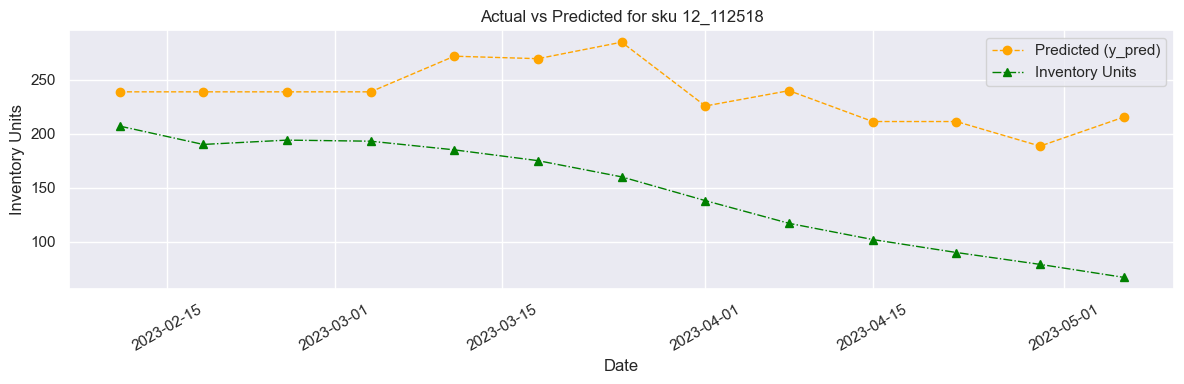

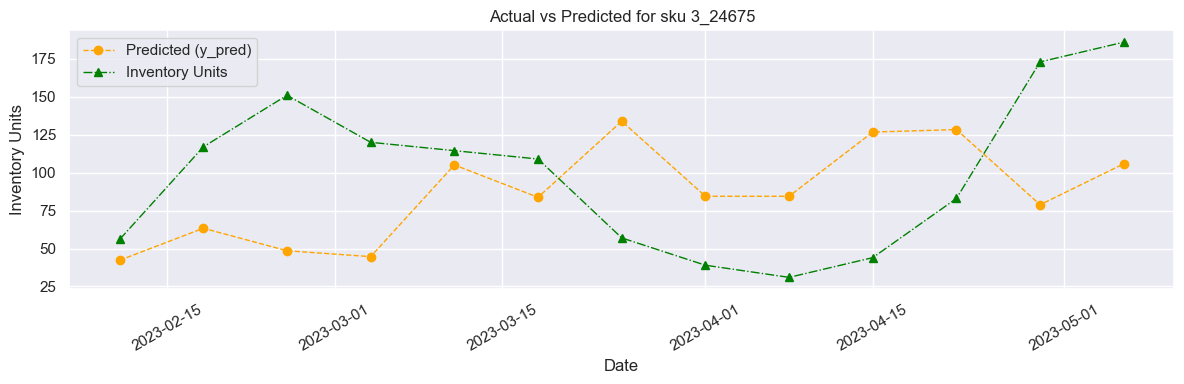

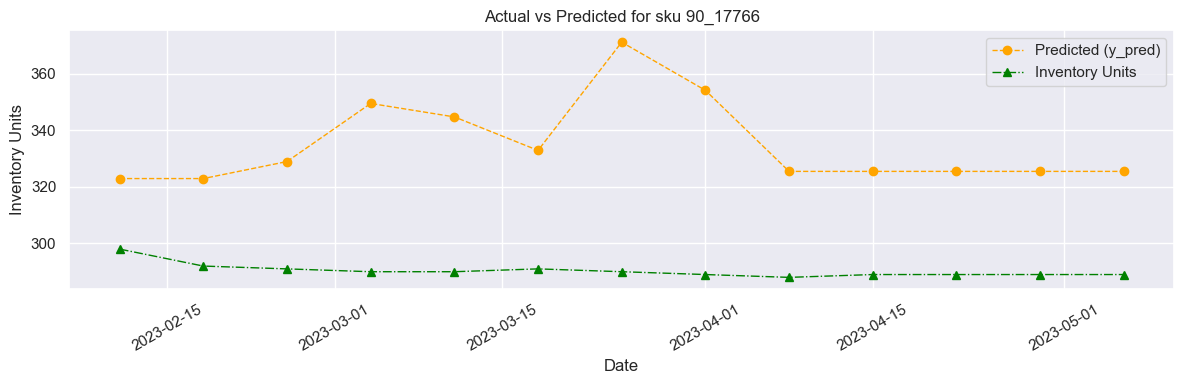

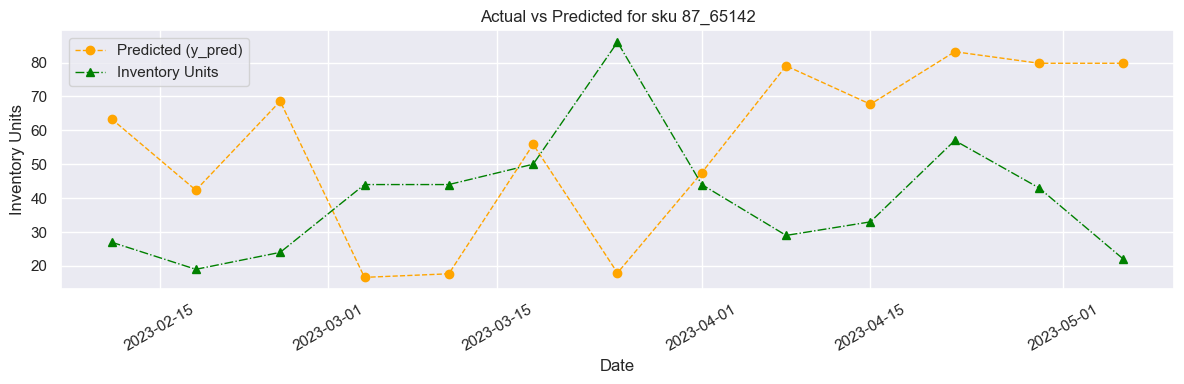

In [19]:
for sku in list_skus:
    utils_plots.plot_real_vs_predicted(df_kaggle, sku)

## 2

In [52]:
X_train.columns

Index(['sku', 'id', 'year_week', 'product_number', 'reporterhq_id',
       'prod_category', 'display_size', 'segment', 'sales_units',
       'day_of_month', 'week_of_month', 'week_of_year', 'month_of_year',
       'year', 'lag_13_inventory', 'lag_14_inventory', 'lag_15_inventory',
       'lag_13_sales', 'lag_14_sales', 'lag_15_sales',
       'rolling_mean_4w_inventory', 'rolling_std_4w_inventory',
       'rolling_sum_4w_inventory', 'rolling_mean_4w_sales',
       'rolling_std_4w_sales', 'rolling_sum_4w_sales'],
      dtype='object')

In [53]:
fc_model.evaluate(y_test, y_pred_train)

Model evaluation completed. RMSE: 67.028


67.028

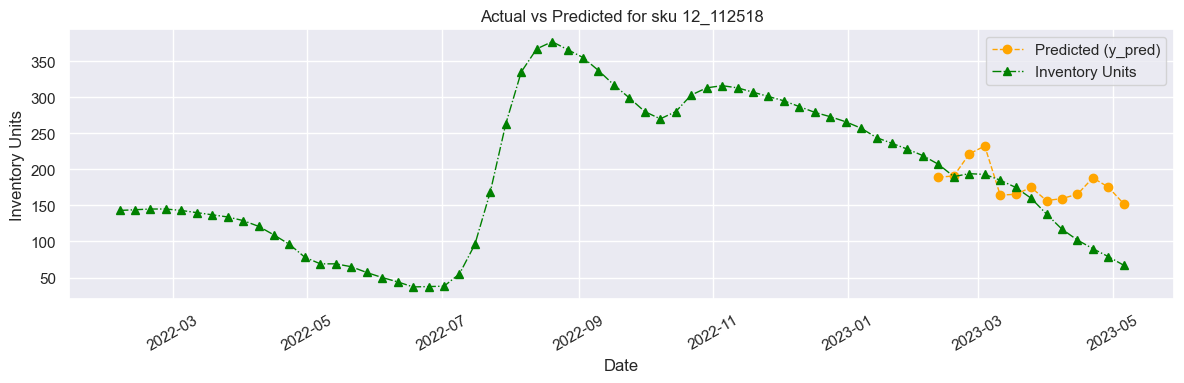

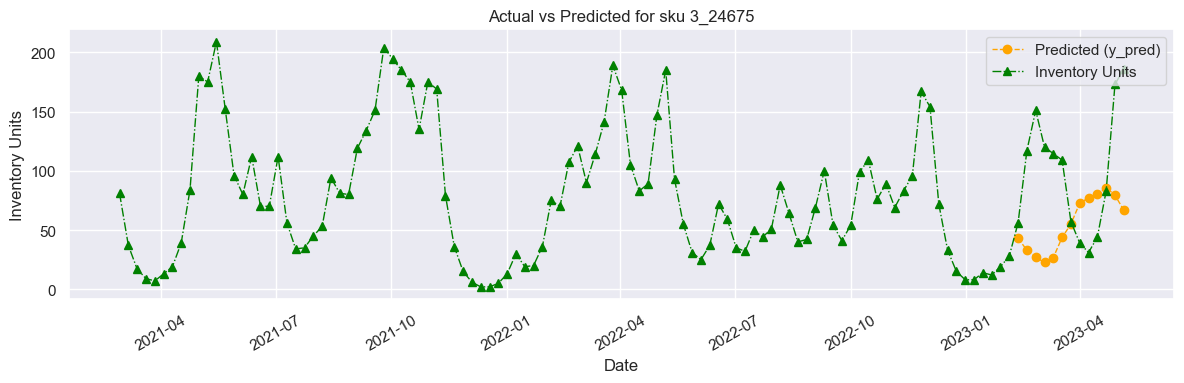

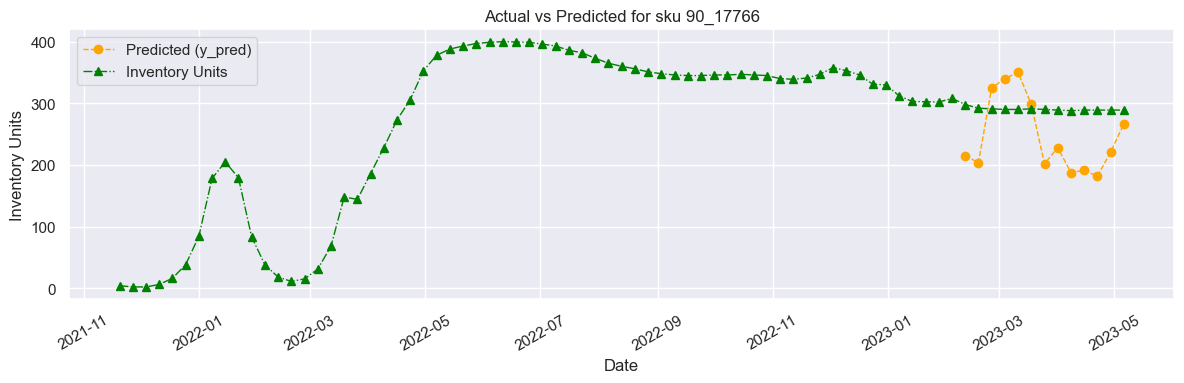

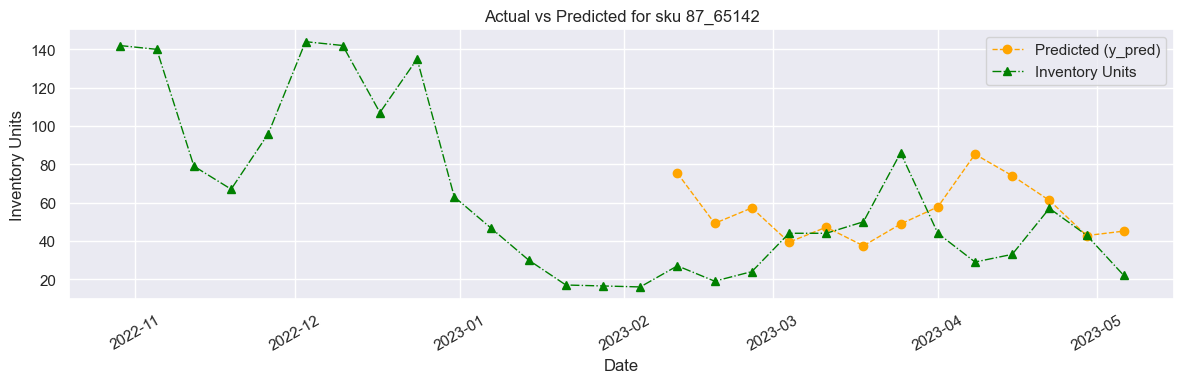

In [34]:
for sku in list_skus:
    utils_plots.plot_real_vs_predicted(df_kaggle, sku, full_history=True)

## 3

In [13]:
X_train.columns

Index(['sku', 'id', 'year_week', 'product_number', 'reporterhq_id',
       'prod_category', 'display_size', 'segment', 'sales_units',
       'day_of_month', 'week_of_month', 'week_of_year', 'month_of_year',
       'year', 'lag_13_inventory', 'lag_14_inventory', 'lag_15_inventory',
       'lag_13_sales', 'lag_14_sales', 'lag_15_sales',
       'rolling_mean_4w_inventory', 'rolling_std_4w_inventory',
       'rolling_sum_4w_inventory', 'rolling_mean_4w_sales',
       'rolling_std_4w_sales', 'rolling_sum_4w_sales'],
      dtype='object')

In [14]:
fc_model.evaluate(y_test, y_pred_train)

Model evaluation completed. RMSE: 63.859


63.859

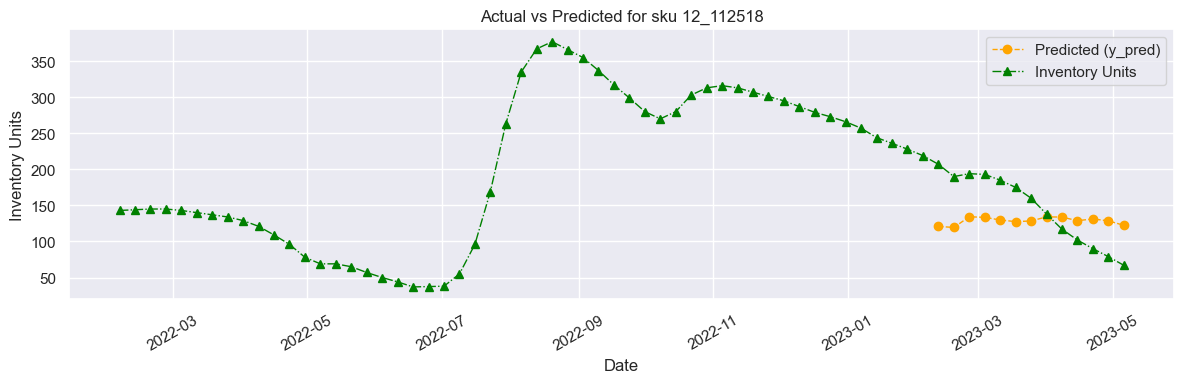

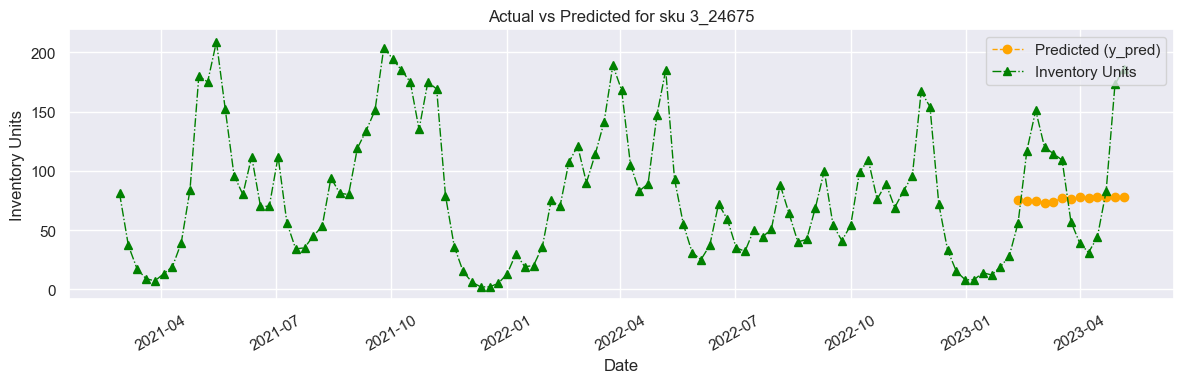

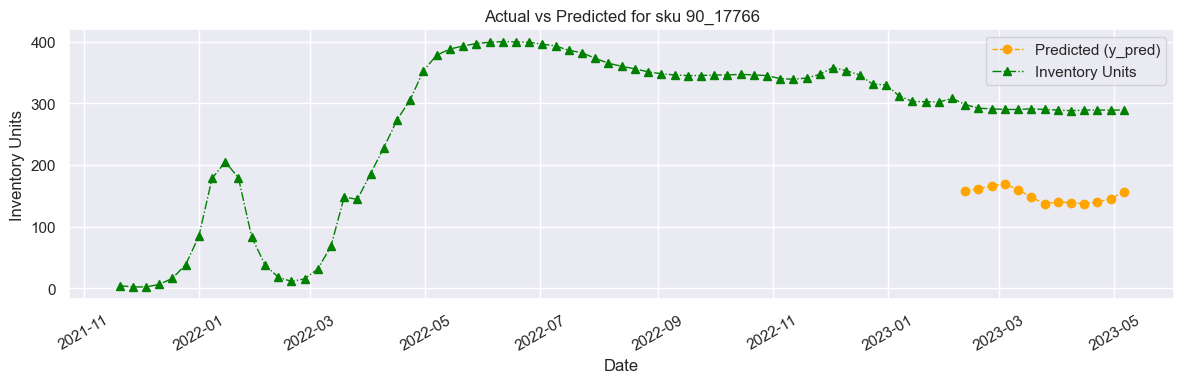

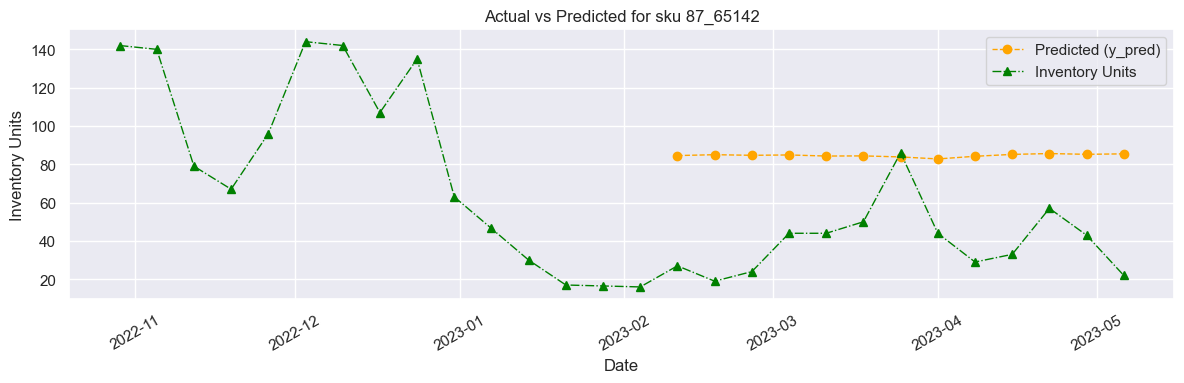

In [ ]:
for sku in list_skus:
    utils_plots.plot_real_vs_predicted(df_kaggle, sku, full_history=True)

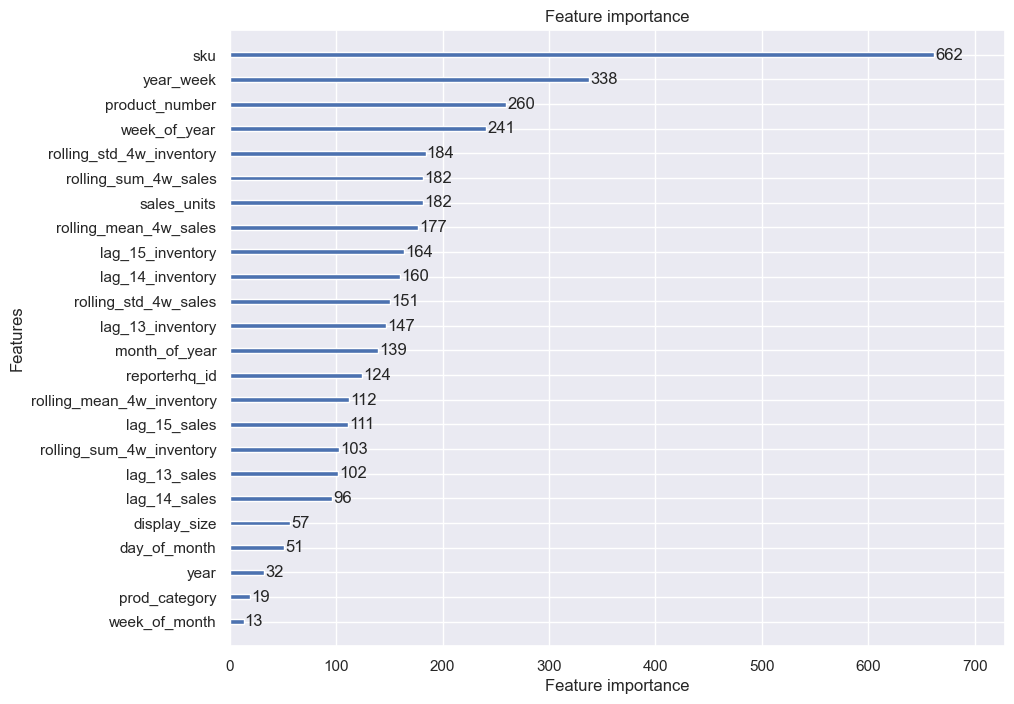

In [16]:
# Plot the feature importance based on "split" (how often a feature is used)
lgb.plot_importance(fc_model.model, importance_type='split', max_num_features=50, figsize=(10, 8))
plt.show()